<h1> <img style="height:5em;" alt="batty" src="https://raw.githubusercontent.com/philippeller/batty/main/batty_logo.svg"/> </h1> 

# BAT to Python (batty)

A small python interface to the Bayesian Analysis Toolkit (BAT.jl) https://github.com/bat/BAT.jl

# Quick Start

## Installation

There are two parts to an installation, one concerning the python side, and one the julia side:

* Python: `pip install batty`

* Julia: `import Pkg; Pkg.add.(["PyJulia", "DensityInterface", "Distributions", "ValueShapes", "TypedTables", "ArraysOfArrays", "BAT"])`

## Minimal Example

The code below is showing a minimal example:
* using a gaussian likelihood and a uniform prior
* generating samples via Metropolis-Hastings
* plotting the resulting sampes
* estimating the integral value via BridgeSampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from batty import BAT_sampler, BAT, Distributions

/mnt/c/Users/peller/work/batty/batty.py:6: UserWarning: Not able to use compiled modules, resulting in (very) slow import
 See https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
  warnings.warn("Not able to use compiled modules, resulting in (very) slow import\n See https://pyjulia.readthedocs.io/en/latest/troubleshooting.html")


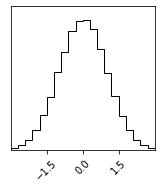

In [2]:
sampler = BAT_sampler(llh=lambda x : -0.5 * x**2, prior_specs=Distributions.Uniform(-3, 3))
sampler.sample();
sampler.corner();

In [3]:
sampler.integrate()

0.4165591088238079+/-0.00020607405882794568

# Usage

## Using Different Algotihms

There are a range of algorihtms available within BAT, and those can be further customized via arguments. Here are just a few examples:

### Integration:

* AHMI:

In [4]:
sampler.integrate(strategy=BAT.AHMIntegration())

0.41993468380372745+/-0.0015153686310618321

* Bridge Sampling:

In [5]:
sampler.integrate(strategy=BAT.BridgeSampling())

0.4166724726365416+/-0.0002060289597245534

### MCMC Sampling:

In [6]:
results = {}

* Metropolis-Hastings:

In [7]:
results['Metropolis-Hastings'] = sampler.sample(strategy=BAT.MCMCSampling(nsteps=10_000, nchains=2))

* Metropolis-Hastings with Accept-Reject weighting:

In [8]:
results['Accept-Reject Weighting'] = sampler.sample(strategy=BAT.MCMCSampling(mcalg=BAT.MetropolisHastings(weighting=BAT.ARPWeighting()), nsteps=10_000, nchains=2))

* Prior Importance Sampling:

In [9]:
results['Prior Importance Sampling'] = sampler.sample(strategy=BAT.PriorImportanceSampler(nsamples=10_000))

* Sobol Sampler:

In [10]:
results['Sobol Quasi Random Numbers'] = sampler.sample(strategy=BAT.SobolSampler(nsamples=10_000))

* Grid Sampler:

In [11]:
results['Grid Points'] = sampler.sample(strategy=BAT.GridSampler(ppa=1000))

Plotting the different results:

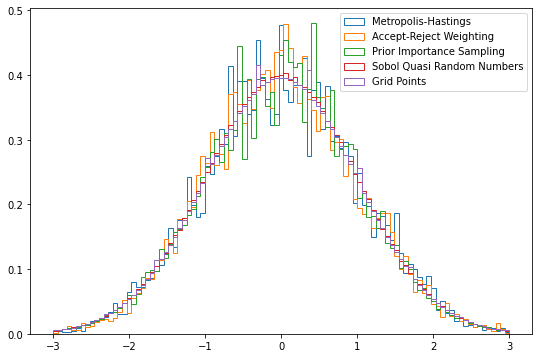

In [12]:
fig = plt.figure(figsize=(9,6))
bins=np.linspace(-3, 3, 100)
for key, item in results.items():
    plt.hist(item.v, weights=item.weight, bins=bins, density=True, histtype="step", label=key);
plt.legend()

# Specifying Priors and Likelihoods

Priors are specified via Julia `Distributions`, multiple Dimensions can be defined via a `dict`, where the `key` is the dimension name and the value the distribution

In [13]:
s = np.array([[0.25, 0.4], [0.9, 0.75]])
prior_specs = {'a' : Distributions.Uniform(-3,3), 'b' : Distributions.MvNormal([1,1], s@s.T)}

The log-likelihood (`llh`) can be any python callable, that returns the log-likelihood values. The first argument to the function is the object with paramneter values, here `x`. If the prior is simple (i.e. like in the example in the beginning, `x` is directly the parameter value). If the prior is specified via a `dict`, then `x` contains a field per parameter with the value.
Any additional `args` to the llh can be given in the sampler, such as here `d` for data:

In [14]:
def llh(x, d):
    return -0.5 * ((x.b[0] - d[0])**2 + (x.b[1] - d[1])**2/4) - x.a

In [15]:
d = [-1, 1]

In [16]:
sampler = BAT_sampler(llh, prior_specs, llh_args=(d,), progress_bar=True)

Let us generate a few samples:

In [17]:
sampler.sample(strategy=BAT.MCMCSampling(nsteps=10_000, nchains=2));

llh at   -11.0996: : 35132it [01:46, 377.76it/s]     

### Some interface to plotting tools are available

* The **G**reat **T**riangular **C**onfusion (GTC) plot:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


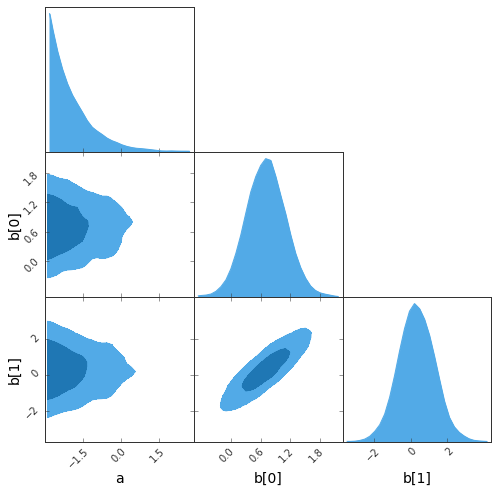

In [18]:
sampler.gtc(figureSize=8, customLabelFont={'size':14}, customTickFont={'size':10});

* The corner plot:

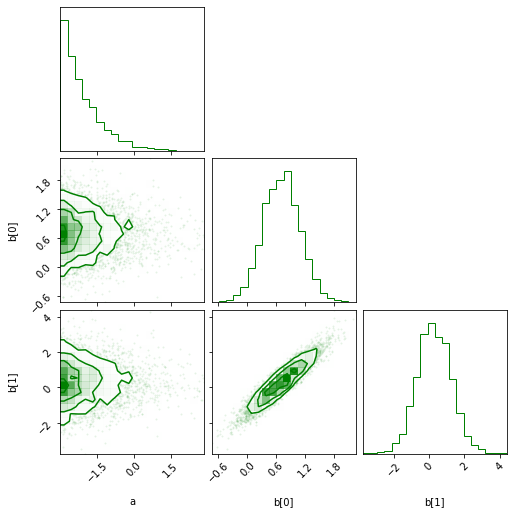

In [19]:
sampler.corner(color='green');

In [20]:
# does not work
#sampler.sample(strategy=BAT.MCMCSampling(nsteps=1000, nchains=2, mcalg=BAT.HamiltonianMC()));

In [21]:
#takes way too long, something wrong
#sampler.sample(strategy=BAT.PartitionedSampling(npartitions=2, sampler=BAT.MCMCSampling(nchains=2, nsteps=100, strict=False), exploration_sampler=BAT.MCMCSampling(nchains=2, nsteps=100, strict=False)))